Generative Adversarial Networks (GANs)
======
Let's implement a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

In [1]:
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

------
## Parameter Settings

In [2]:
latent_dims = 10
num_epochs = 20
batch_size = 128
learning_rate = 2e-4
use_gpu = True

-------------------
## MNIST Data Loading

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


-----------------------
## Model Structure

We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.


In [4]:
class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

In [5]:
discriminator = Discriminator()
generator = Generator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033985


--------
## Train GAN

In [6]:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) + # label_real = 1
            F.binary_cross_entropy(fake_pred, label_fake)) # label_fake = 0
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 20] average loss generator vs. discrim.: 5.964225 vs. 0.301990
Epoch [2 / 20] average loss generator vs. discrim.: 1.749347 vs. 0.532686
Epoch [3 / 20] average loss generator vs. discrim.: 1.983144 vs. 0.469887
Epoch [4 / 20] average loss generator vs. discrim.: 2.693531 vs. 0.392934
Epoch [5 / 20] average loss generator vs. discrim.: 6.669865 vs. 0.047437
Epoch [6 / 20] average loss generator vs. discrim.: 7.216965 vs. 0.067786
Epoch [7 / 20] average loss generator vs. discrim.: 5.787967 vs. 0.116261
Epoch [8 / 20] average loss generator vs. discrim.: 5.505635 vs. 0.082238
Epoch [9 / 20] average loss generator vs. discrim.: 5.877388 vs. 0.109915
Epoch [10 / 20] average loss generator vs. discrim.: 5.680527 vs. 0.080405
Epoch [11 / 20] average loss generator vs. discrim.: 6.105471 vs. 0.087367
Epoch [12 / 20] average loss generator vs. discrim.: 5.905042 vs. 0.157107
Epoch [13 / 20] average loss generator vs. discrim.: 5.293572 vs. 0.073148
Epoch [14 / 20] avera

--------------------
## Plot Training Curves



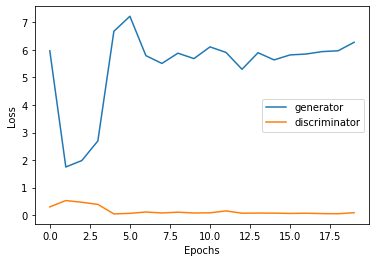

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

-----------------------------
## Load Pre-Trained GAN


In [8]:
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/dcgan.pth", "./pretrained/dcgan.pth")
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/dcgan_discriminator.pth", "./pretrained/dcgan_discriminator.pth")
generator.load_state_dict(torch.load('./pretrained/dcgan.pth'))
discriminator.load_state_dict(torch.load('./pretrained/dcgan_discriminator.pth'))
print('done')

# this is how the GAN parameters can be saved:
# torch.save(generator.state_dict(), './pretrained/G_checkpoint_idx.pth')
# torch.save(discriminator.state_dict(), './pretrained/D_checkpoint_idx.pth')

downloading ...
done


-------------------------------------------------
## Sample Latent Vector from Prior (GAN as Generator)

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution. However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

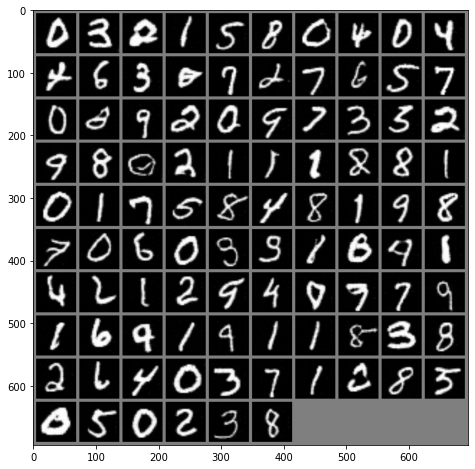

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()

----------------------------
## Interpolate in Latent Space


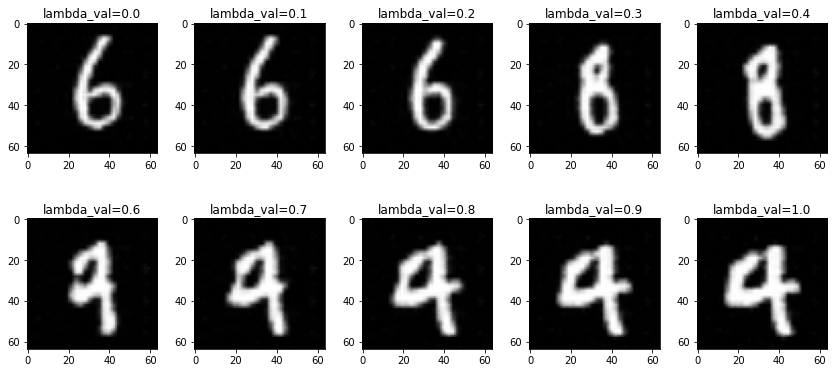

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 